In [1]:
pip install -q seaborn tensorflow pandas numpy matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
columns = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
           'Acceleration', 'Model Year', 'Origin']

# Load the dataset
dataset = pd.read_csv(url, names=columns, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

# Display the last few rows
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# Remove missing values
dataset = dataset.dropna()

# Convert 'Origin' (1,2,3) → ('USA', 'Europe', 'Japan')
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# One-hot encoding
dataset = pd.get_dummies(dataset, columns=['Origin'])

# Display cleaned data
dataset.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,False,False,True
1,15.0,8,350.0,165.0,3693.0,11.5,70,False,False,True
2,18.0,8,318.0,150.0,3436.0,11.0,70,False,False,True
3,16.0,8,304.0,150.0,3433.0,12.0,70,False,False,True
4,17.0,8,302.0,140.0,3449.0,10.5,70,False,False,True


In [5]:
# 80% Training, 20% Testing
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Features (X) & Labels (Y)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')  # Target variable
test_labels = test_features.pop('MPG')


In [6]:
# Create a normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

# Compute mean & std deviation
normalizer.adapt(np.array(train_features))

# Print mean values
print(normalizer.mean.numpy())


[[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
  7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]]


In [7]:
# Create a normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

# Compute mean & std deviation
normalizer.adapt(np.array(train_features))

# Print mean values
print(normalizer.mean.numpy())


[[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
  7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]]


In [8]:
# Build a simple linear regression model
linear_model = tf.keras.Sequential([
    normalizer,  # Normalization layer
    layers.Dense(1)  # Single neuron for regression
])

# Compile the model
linear_model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_absolute_error')

# Train for 100 epochs
history = linear_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)


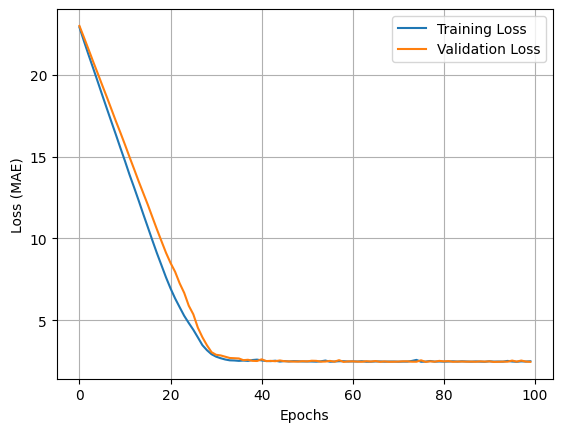

Test MAE: 2.470838785171509


In [9]:
# Visualize Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.show()

# Test Model Performance
test_results = {}
test_results['Linear Model'] = linear_model.evaluate(test_features, test_labels, verbose=0)
print("Test MAE:", test_results['Linear Model'])


In [10]:
# Function to build DNN model
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,  # Normalization layer
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')
    return model

# Create the DNN model
dnn_model = build_and_compile_model(normalizer)

# Train the DNN model
history = dnn_model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=100)

# Evaluate the DNN model
test_results['DNN Model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
print("Test MAE (DNN):", test_results['DNN Model'])


Test MAE (DNN): 1.6874966621398926


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


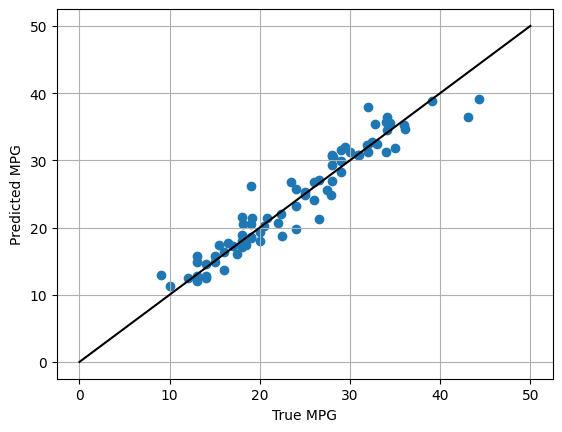

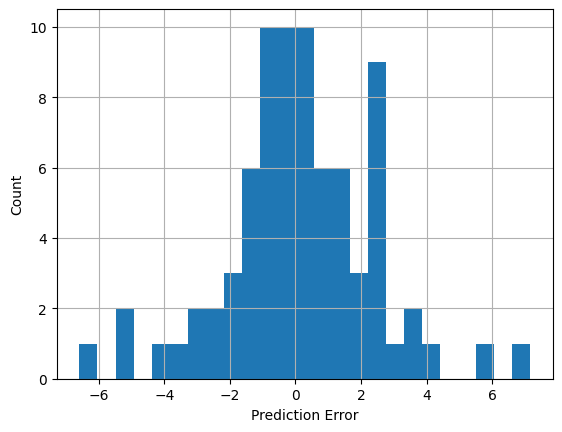

In [11]:
# Make predictions using the trained model
test_predictions = dnn_model.predict(test_features).flatten()

# Scatter plot: True vs Predicted
plt.scatter(test_labels, test_predictions)
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
plt.plot([0, 50], [0, 50], color='black')  # Reference line
plt.grid(True)
plt.show()

# Plot the error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [12]:
# Save the trained model
dnn_model.save("fuel_efficiency_model.keras")

# Load the model
reloaded_model = tf.keras.models.load_model("fuel_efficiency_model.keras")

# Verify the model performance
test_results['Reloaded Model'] = reloaded_model.evaluate(test_features, test_labels, verbose=0)
print("Reloaded Model Test MAE:", test_results['Reloaded Model'])


Reloaded Model Test MAE: 1.6874966621398926
